In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

percap_path = Path("./dataset/GCB2022v27_percapita_flat.csv")
total_path   = Path("./dataset/GCB2022v27_MtCO2_flat.csv")

df_pc = pd.read_csv(percap_path)
df_tt = pd.read_csv(total_path)

df_pc = df_pc.rename(columns={
    "ISO 3166-1 alpha-3": "iso3",
    "Total":  "co2_pc_total",
    "Coal":   "co2_pc_coal",
    "Oil":    "co2_pc_oil",
    "Gas":    "co2_pc_gas",
    "Cement": "co2_pc_cement",
    "Flaring":"co2_pc_flaring",
    "Other":  "co2_pc_other",})

df_tt = df_tt.rename(columns={
    "ISO 3166-1 alpha-3": "iso3",
    "Total": "co2_total_mt" })

#select data year (2000–2023)
df_pc = df_pc[(df_pc["Year"]>=2000) & (df_pc["Year"]<=2023)].copy()
df_tt = df_tt[(df_tt["Year"]>=2000) & (df_tt["Year"]<=2023)].copy()

sector_cols = [c for c in df_pc.columns if c.startswith("co2_pc_")]
df_pc[sector_cols] = df_pc[sector_cols].fillna(0.0)

big_pop = ['China',"India","Indonesia","United States","Nigeria","Pakistan","Brazil","Japan","Thailand","Russia"]          
small_rich = ["Singapore","Qatar","Norway","Maldives","Bhutan","Brunei Darussalam","Kuwait","United Arab Emirates","New Zealand","Switzerland"]      
focus = big_pop + small_rich

outdir = Path("./figs"); outdir.mkdir(exist_ok=True)



In [30]:
def save_tight(name):
    plt.tight_layout()
    plt.savefig(outdir / name, dpi=300)
    plt.show()

### Find a trends for each group

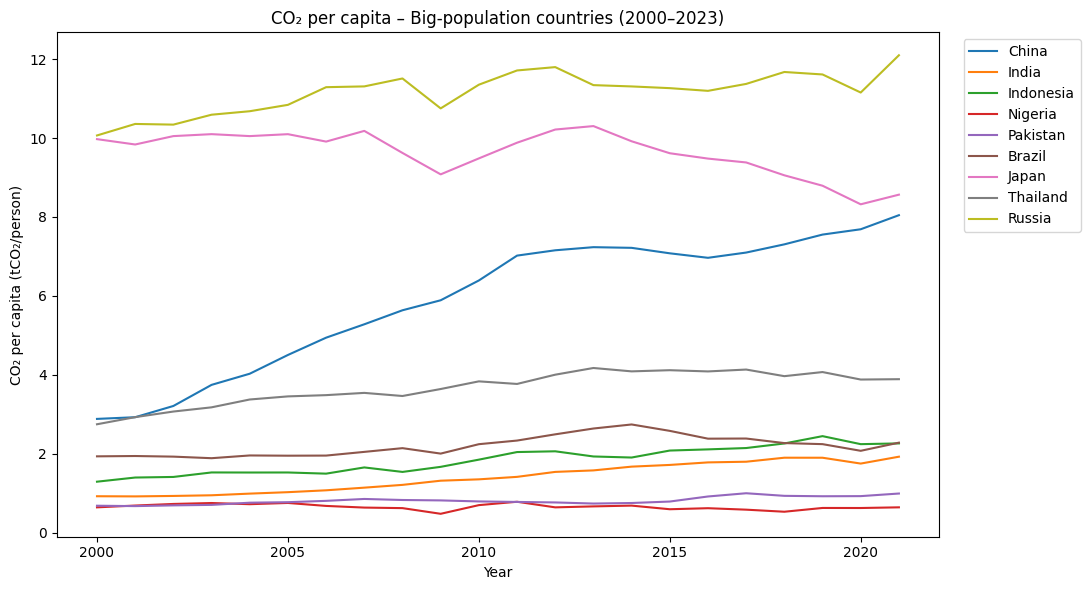

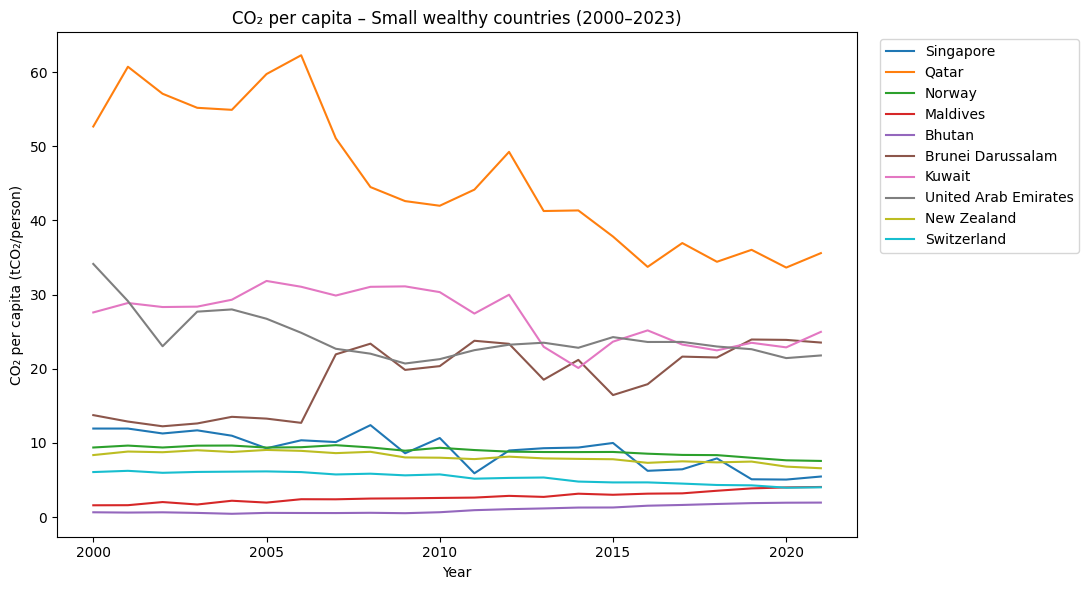

In [31]:
def plot_trend(countries, title, fname):
    plt.figure(figsize=(11,6))
    for c in countries:
        tmp = df_pc[df_pc["Country"] == c].sort_values("Year")
        if tmp.empty: 
            continue
        plt.plot(tmp["Year"], tmp["co2_pc_total"], label=c)
    plt.title(title)
    plt.xlabel("Year"); plt.ylabel("CO₂ per capita (tCO₂/person)")
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", ncol=1)
    save_tight(fname)

plot_trend(big_pop,   "CO₂ per capita – Big-population countries (2000–2023)",
           "trend_big_population.png")
plot_trend(small_rich,"CO₂ per capita – Small wealthy countries (2000–2023)",
           "trend_small_wealthy.png")

Trends of per-capita CO₂ emissions (2000–2023). Small wealthy countries (e.g., Qatar, Singapore, Norway) consistently show high per-capita emissions, while large developing countries (e.g., India, Indonesia, Nigeria) remain at low levels despite gradual increases. This contrast illustrates how development stage influences emission intensity.

### Bar Chart 

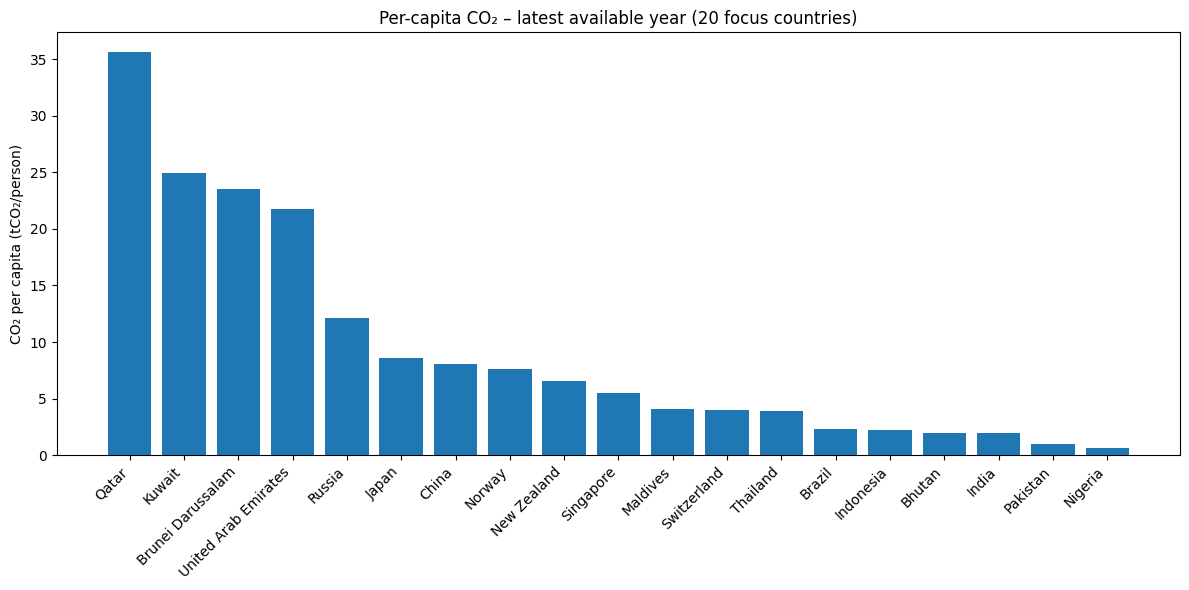

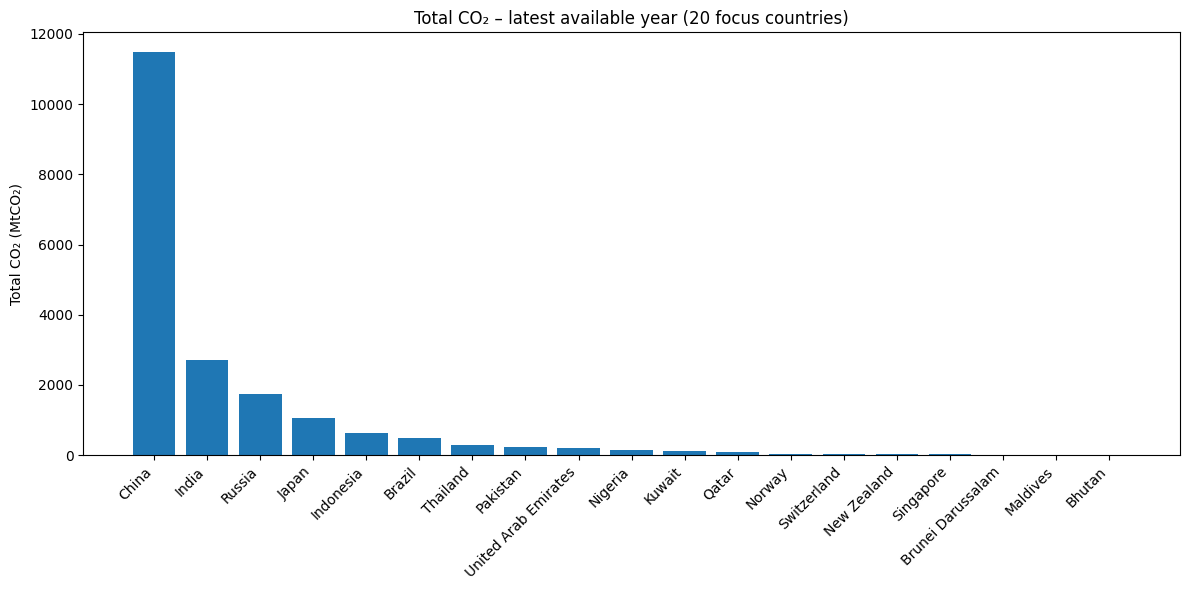

In [32]:
pc_latest = (df_pc.sort_values("Year")
             .groupby("Country", as_index=False).tail(1))
tt_latest = (df_tt.sort_values("Year")
             .groupby("Country", as_index=False).tail(1))

pc_latest_sel = pc_latest[pc_latest["Country"].isin(focus)].copy()
tt_latest_sel = tt_latest[tt_latest["Country"].isin(focus)].copy()

pc_latest_sel = pc_latest_sel.sort_values("co2_pc_total", ascending=False)
tt_latest_sel = tt_latest_sel.sort_values("co2_total_mt", ascending=False)

# Latest Year – Per Capita
plt.figure(figsize=(12,6))
plt.bar(pc_latest_sel["Country"], pc_latest_sel["co2_pc_total"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("CO₂ per capita (tCO₂/person)")
plt.title("Per-capita CO₂ – latest available year (20 focus countries)")
save_tight("bar_percapita_latest_focus.png")

# Latest Year – Total
plt.figure(figsize=(12,6))
plt.bar(tt_latest_sel["Country"], tt_latest_sel["co2_total_mt"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total CO₂ (MtCO₂)")
plt.title("Total CO₂ – latest available year (20 focus countries)")
save_tight("bar_total_latest_focus.png")

- Per-capita CO₂ emissions (latest year) for 20 selected countries. This metric allows fair comparison across countries of different population sizes. The results highlight that small but wealthy nations (Qatar, Kuwait, Singapore) emit disproportionately high CO₂ per person, while highly populated developing countries (India, Nigeria) show very low per-capita emissions despite having large total emissions. This contrast emphasizes the equity challenge in global climate negotiations.
- Total CO₂ emissions (latest available year, 20 selected countries). Despite low per-capita values, populous nations such as China and India contribute the most to global emissions in total, while small countries with high per-capita emissions contribute little to global totals.

## find signal for each source sectors

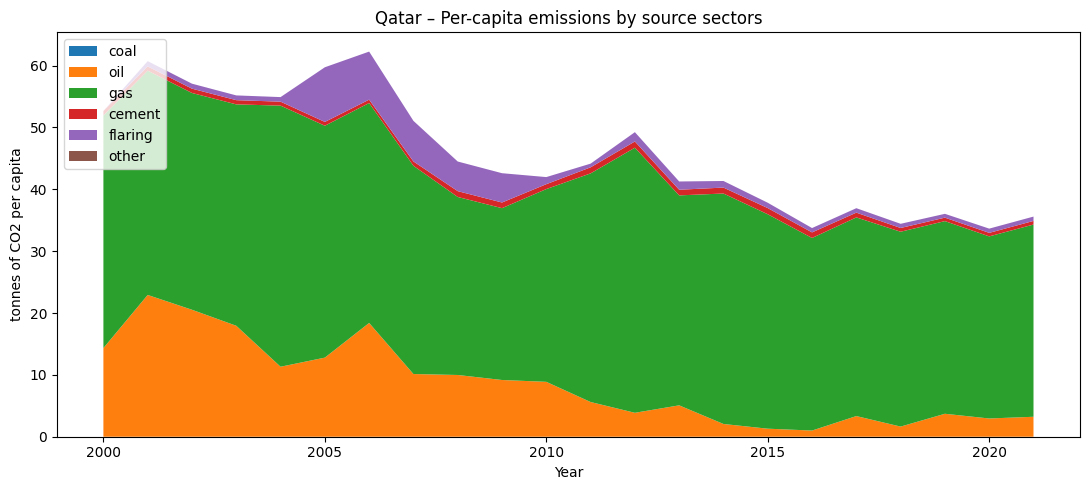

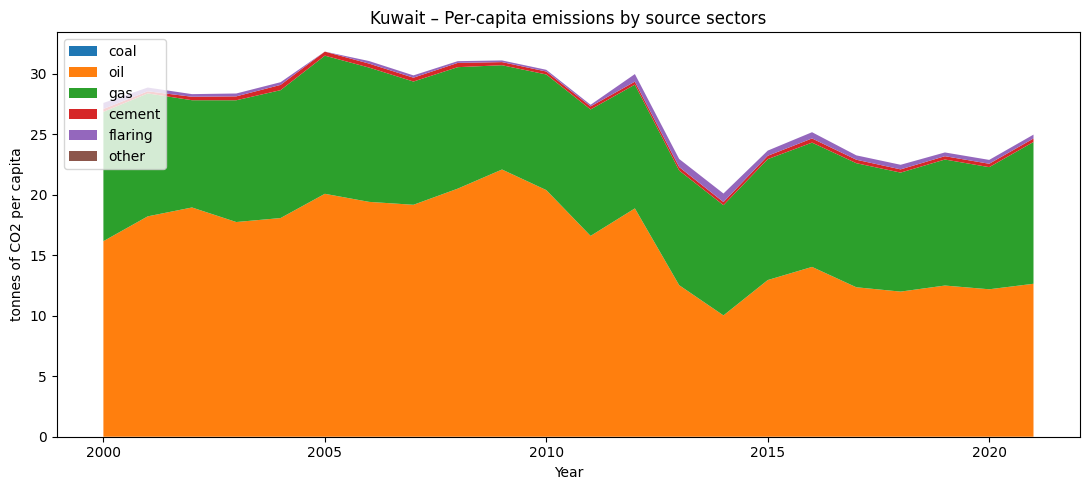

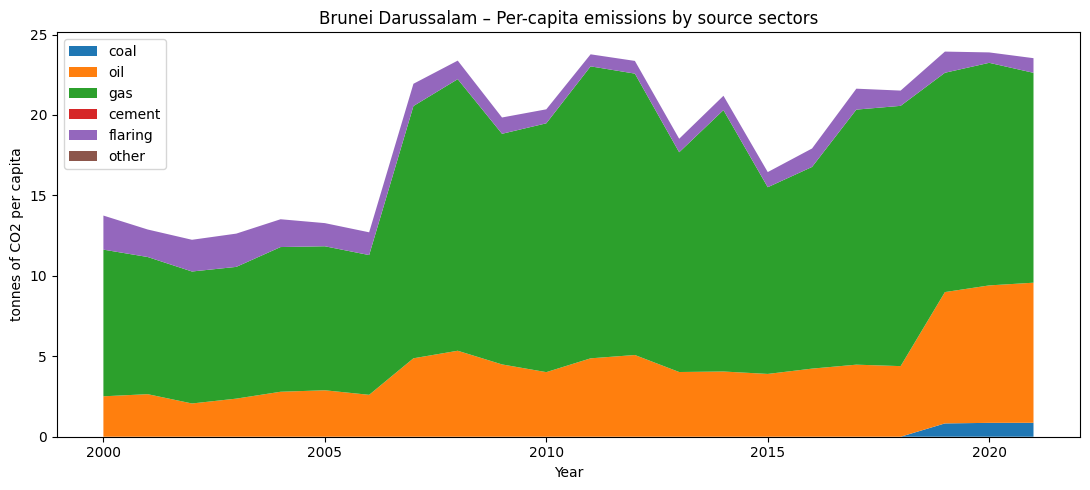

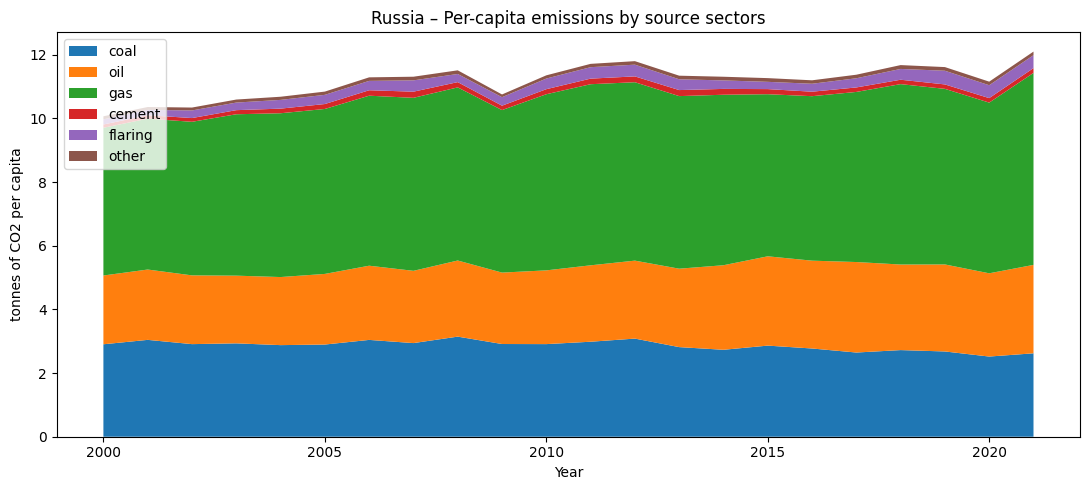

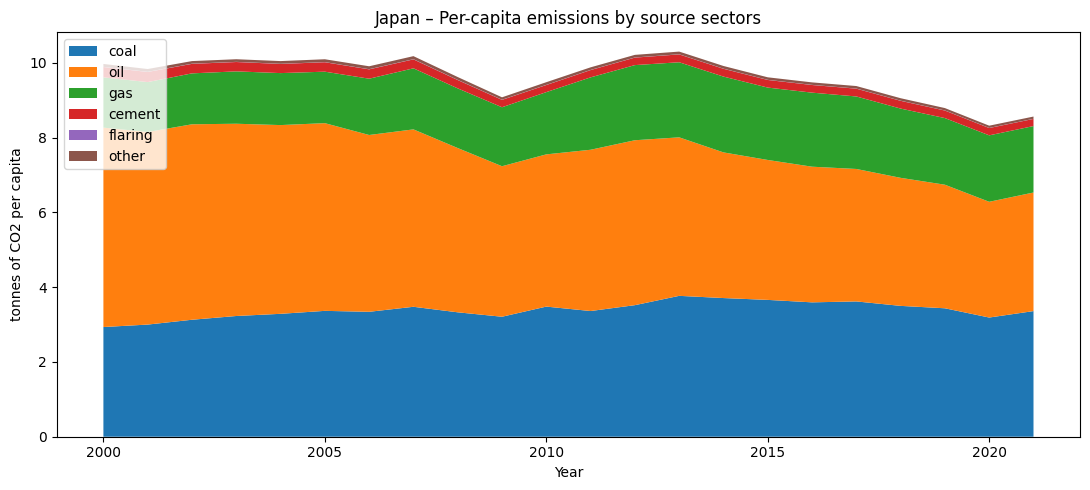

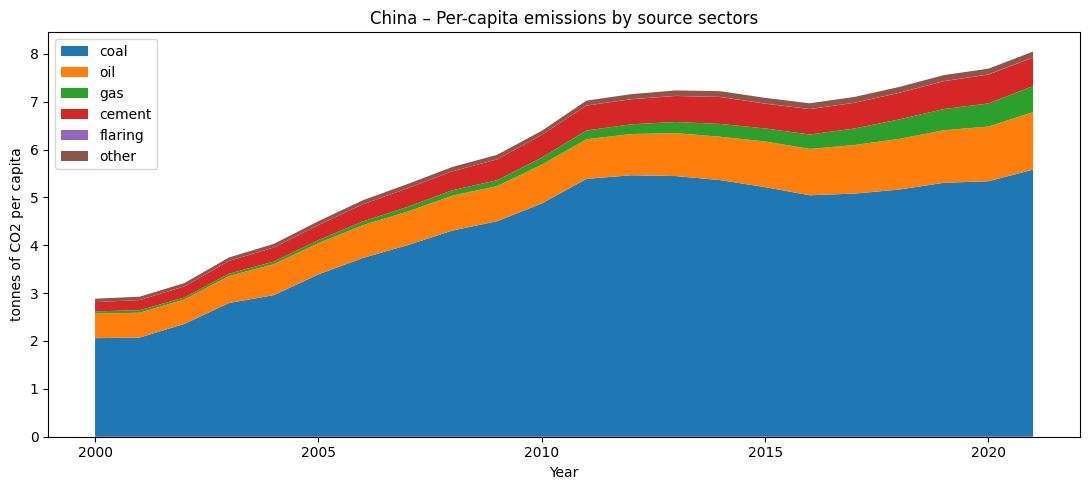

In [33]:
def top_k_countries(group_list, k=3):
    sub = pc_latest[pc_latest["Country"].isin(group_list)].copy()
    sub = sub.sort_values("co2_pc_total", ascending=False).head(k)
    return sub["Country"].tolist()

reps_small = top_k_countries(small_rich, k=3)
reps_big   = top_k_countries(big_pop, k=3)

def plot_stack(country):
    cols = ["co2_pc_coal","co2_pc_oil","co2_pc_gas","co2_pc_cement","co2_pc_flaring","co2_pc_other"]
    tmp = df_pc[df_pc["Country"]==country].sort_values("Year")
    if tmp.empty: 
        return
    plt.figure(figsize=(11,5))
    plt.stackplot(tmp["Year"], *[tmp[c] for c in cols],
                  labels=[c.replace("co2_pc_","") for c in cols])
    plt.title(f"{country} – Per-capita emissions by source sectors")
    plt.xlabel("Year"); plt.ylabel("tonnes of CO2 per capita")
    plt.legend(loc="upper left")
    save_tight(f"stack_sector_{country.replace(' ','_')}.png")

for c in reps_small + reps_big:
    plot_stack(c)

Per-capita CO₂ emissions by source sectors. Small wealthy countries (e.g., Singapore) rely heavily on oil and gas, while large developing countries (e.g., India) depend predominantly on coal. This indicates different development models and energy structures requiring tailored mitigation policies.

### Correlation Heatmap

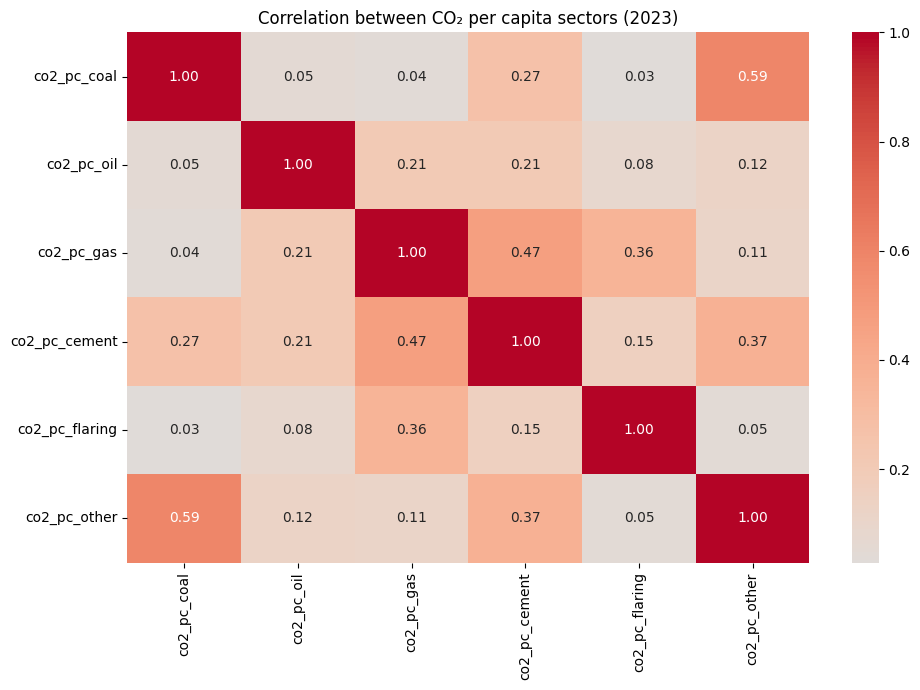

In [ ]:
corr = df_pc[["co2_pc_coal","co2_pc_oil","co2_pc_gas",
                "co2_pc_cement","co2_pc_flaring","co2_pc_other"]].corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation between CO₂ per capita sectors")
plt.tight_layout()
plt.show()